# Предсказание температуры расплава стали для ООО «Так закаляем сталь»

# Цель проекта
Построение модели машинного обучения, которая предскажет температуру стали для оптимизации производственных расходов (потребление электроэнергии) на этапе обработки стали. 

# Описание этапа обработки
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — **изменяют её состав** — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. **tribe**, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. **slab**, «плита»).

# Описание данных
Данные состоят из файлов, полученных из разных источников:

- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец **key** содержит **номер партии**. В файлах может быть несколько строк с одинаковым значением key: они соответствуют **разным итерациям обработки**.

# Дополнительные сведения от заказчика

- Целевая переменная target - последняя температура по всей партии;
- Целевая метрика - MAE (нужно получить не более 6.8 на тестовой выборке);
- Использовать, как признак, можно только ПЕРВУЮ температуру по партии, а промежуточные - нельзя;
- Пропуски в data_bulk_new и data_wire_new нужно заполнить нулями;
- Таблицы о времени подачи в итоговую таблицу не идут;
- Удалить ключ с отрицательной реактивной мощностью;
- Удалить все ключи с температурой ниже 1500 перед объединением выборок;
- Удалить записи с ключом с одним замером параметров;
- Необходимио агрегировать данные в тех таблицах, где для одной партии имеются несколько итераций (строк).

Использовать RANDOM_STATE = 280823, где это прописано документацией.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
pd.options.mode.chained_assignment = None


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)

from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor

from lightgbm import LGBMRegressor
!pip install -U --user scikit-learn

## Исследовательскийанализ данных

In [2]:
df_arc = pd.read_csv('/datasets/data_arc_new.csv')

df_bulk = pd.read_csv('/datasets/data_bulk_new.csv')

df_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')

df_gas = pd.read_csv('/datasets/data_gas_new.csv')

df_temp = pd.read_csv('/datasets/data_temp_new.csv')

df_wire = pd.read_csv('/datasets/data_wire_new.csv')

df_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

In [3]:
def get_df_info(df):
    '''Ф-ия для анализа данных'''
    display(df.head(5))
    display(df.info())
    display(df.describe().round())
    display('Кол-во пропусков:', df.isna().sum())
    display('Доля пропусков:', df.isna().mean().mean())
    print('Кол-во явных дубликатов:', df.duplicated().sum())

### Данные об электродах (data_arc_new)

#### Анализ данных

In [4]:
 get_df_info(df_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Активная мощность,Реактивная мощность
count,14876.0,14876.0,14876.0
mean,1615.0,1.0,0.0
std,935.0,0.0,6.0
min,1.0,0.0,-715.0
25%,806.0,0.0,0.0
50%,1617.0,1.0,0.0
75%,2429.0,1.0,1.0
max,3241.0,1.0,1.0


'Кол-во пропусков:'

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

'Доля пропусков:'

0.0

Кол-во явных дубликатов: 0


Рассмотрим активную и реактивную мощность на предмет выбросов, для чего посмотрим значения активной и реактивной мощнности на разных квантилях.

In [5]:
(
    df_arc[['Активная мощность','Реактивная мощность']]
    .quantile([0.0012, 0.01, .5, .99, .9988])
    .style.format("{:,.2f}")
 )

,Активная мощность,Реактивная мощность
0.0012,0.24,0.17
0.01,0.27,0.19
0.5,0.60,0.44
0.99,1.34,1.03
0.9988,1.41,1.17


Можно сделать вывод о том, что значение (-715.479924) реактивноой мощности является выбросом. Ограничим значение реактивной мощности боьше 0 для построения графика.

In [6]:
df_plot_reactive = df_arc[df_arc['Реактивная мощность']>=0]

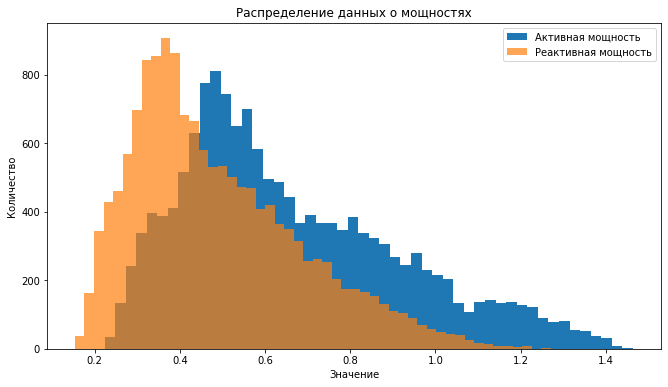

In [7]:
plt.figure(figsize=(11,6))
df_arc['Активная мощность'].plot(kind='hist', bins=50, legend=True)
df_plot_reactive['Реактивная мощность'].plot(kind='hist', bins=50, legend=True, alpha=0.7)
plt.title('Распределение данных о мощностях')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.show()

**Вывод**

Предварительный обзор "Данных об электродах" показал, что:
- несоответствие наименования колонок (единый стиль);
- пропусков нет;
- явных дубликатов нет;
- выявлен выброс в значении реактивной мощности;
- выявлено несоответствие типу данных колонок начала и конца нагрева дугой;
- распределение мощностей близко к нормальному.

#### Предобработка данных

**План предобработки:**
- переименовать наименование колонок;
- привести тип данных колонок начала и конца нагрева дугой к datetime;
- удалить отрицательные значения реактивной мощности;
- удалить ключи с единичным замером;
- вычислить полную мощность;
- вычислить значение энергии;
- агрегировать значения мощностей по ключу.

Переименуем наименование колонок

In [8]:
df_arc.rename(columns={'Начало нагрева дугой': 'heating_time_start',
                       'Конец нагрева дугой': 'heating_time_end',
                       'Активная мощность': 'active_power',
                       'Реактивная мощность': 'reactive_power'},
              inplace=True)

Изменим тип данных колонок начала и конца нагрева дугой

In [9]:
df_arc['heating_time_start'] = pd.to_datetime(df_arc['heating_time_start'], format='%Y-%m-%dT%H:%M:%S')
df_arc['heating_time_end'] = pd.to_datetime(df_arc['heating_time_end'], format='%Y-%m-%dT%H:%M:%S')
df_arc.dtypes

key                            int64
heating_time_start    datetime64[ns]
heating_time_end      datetime64[ns]
active_power                 float64
reactive_power               float64
dtype: object

Удалим отрицательное значение реактивной мощности

In [10]:
df_arc = df_arc[df_arc['reactive_power']>=0]

  Удалим все записи ключей из одного замера

In [11]:
df_arc_1 = len(df_arc)
X = df_arc['key'].value_counts()
df_arc_del = df_arc[df_arc.key.isin(X[X.values > 1].index)]

# Проверка удаления
print('Кол-во удаленных ключей:', df_arc_1 - len(df_arc_del))
print('Кол-во уникальных значений ключей в порядке возростания: \n', df_arc_del['key'].value_counts().sort_values().head(10))

Кол-во удаленных ключей: 39
Кол-во уникальных значений ключей в порядке возростания: 
 3149    2
1631    2
2455    2
1612    2
1105    2
514     2
1002    2
1244    2
776     2
3143    2
Name: key, dtype: int64


Для того, чтобы дополнить датасет новым признаком энергией (energy), необходимо найти:
1) Поную мощность (full_power), определим по формуле:

$$
full.power = \sqrt{(active.power)^2 + (reactive.power)^2}
$$

2) Время затраченное на нагрев (time_heat) в секундах, определим по формуле:

$$
time.heat =heating.time.end - heating.time.start
$$

3) Найдем энергию (energy) по формуле:

$$
energy = {full.power} * {time.heat}
$$

Найдем полную мощность по формуле (1) и чтобы избежать мультиколлениарности, удалим колноки с активной и реактивной мощностью

In [12]:
df_arc_del['full_power'] = np.sqrt(df_arc_del['active_power']**2 + df_arc_del['reactive_power']**2)
df_arc_del = df_arc_del.drop(['active_power', 'reactive_power'], axis=1)
df_arc_del.head()

,key,heating_time_start,heating_time_end,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,1.079934


Найдем время затраченное на нагрев по формуле (2)

In [13]:
df_arc_del['time_heat'] = (df_arc_del['heating_time_end'] - df_arc_del['heating_time_start']).dt.total_seconds()
df_arc_del.head()

,key,heating_time_start,heating_time_end,full_power,time_heat
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.371123,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.902319,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.722536,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.642824,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,1.079934,148.0


Найдем затраченную энергию на нагрев по формуле (3)

In [14]:
df_arc_del['energy'] = df_arc_del['time_heat'] * df_arc_del['full_power']
df_arc_del.head()

,key,heating_time_start,heating_time_end,full_power,time_heat,energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.371123,228.0,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.902319,185.0,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.722536,172.0,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.642824,365.0,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,1.079934,148.0,159.830252


Агрегируем значения данных по ключу

In [15]:
df_arc_del = df_arc_del.groupby('key').agg(np.sum)
df_arc_del.head(5)

,full_power,time_heat,energy
key,,,
1,3.718736,1098.0,770.282114
2,2.588349,811.0,481.760005
3,5.019223,655.0,722.837668
4,3.400038,741.0,683.455597
5,2.816980,869.0,512.169934


Проверим преобразованный датасет с использованием ф-ии get_df_info

In [16]:
get_df_info(df_arc_del)

,full_power,time_heat,energy
key,,,
1,3.718736,1098.0,770.282114
2,2.588349,811.0,481.760005
3,5.019223,655.0,722.837668
4,3.400038,741.0,683.455597
5,2.816980,869.0,512.169934


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3175 entries, 1 to 3241
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   full_power  3175 non-null   float64
 1   time_heat   3175 non-null   float64
 2   energy      3175 non-null   float64
dtypes: float64(3)
memory usage: 99.2 KB


None

,full_power,time_heat,energy
count,3175.0,3175.0,3175.0
mean,4.0,803.0,662.0
std,1.0,326.0,305.0
min,1.0,119.0,50.0
25%,3.0,578.0,453.0
50%,4.0,776.0,625.0
75%,5.0,987.0,831.0
max,15.0,4189.0,4546.0


'Кол-во пропусков:'

full_power    0
time_heat     0
energy        0
dtype: int64

'Доля пропусков:'

0.0

Кол-во явных дубликатов: 0


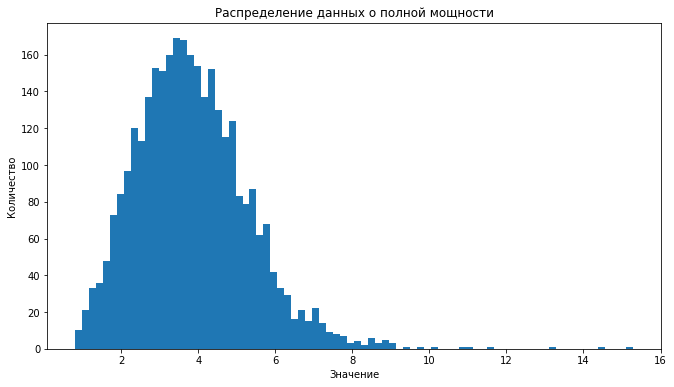

In [17]:
plt.figure(figsize=(11,6))
df_arc_del['full_power'].plot(kind='hist', bins=80)
plt.title('Распределение данных о полной мощности')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.show()

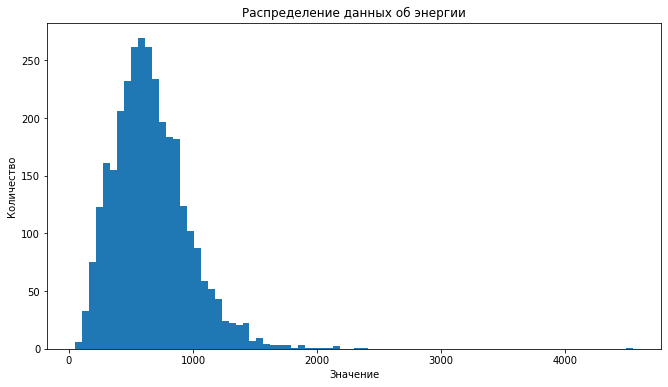

In [18]:
plt.figure(figsize=(11,6))
df_arc_del['energy'].plot(kind='hist', bins=80)
plt.title('Распределение данных об энергии')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.show()

**Вывод** 

**В результате предобработки данных об электродах выполнено:**
- наименования колнок приведены к единому стилю;
- тип данных колонок начала и конца нагрева дугой приведен к datetime;
- удалено отрицательное значения реактивной мощности;
- удалены ключи с единичным замером;
- вычеслен дополнительный признак полной мощности;
- вычеслен дополнительный признак энергия;
- проведено агрегирование значений данных датасета по ключу.

В результате предобработки данных, пропусков и явных дубликатов нет.

### Данные о подаче сыпучих материалов (объём) (data_bulk_new)



#### Анализ данных

In [19]:
get_df_info(df_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.0,252.0,22.0,1298.0,1014.0,77.0,576.0,25.0,1.0,19.0,176.0,177.0,2450.0,18.0,2806.0,2248.0
mean,1624.0,39.0,253.0,114.0,104.0,107.0,119.0,306.0,49.0,76.0,83.0,77.0,260.0,181.0,170.0,161.0
std,933.0,18.0,21.0,75.0,48.0,82.0,72.0,191.0,NaN,22.0,26.0,60.0,121.0,46.0,66.0,52.0
min,1.0,10.0,228.0,6.0,12.0,11.0,17.0,47.0,49.0,63.0,24.0,8.0,53.0,151.0,16.0,1.0
25%,816.0,27.0,242.0,58.0,72.0,70.0,70.0,155.0,49.0,66.0,64.0,25.0,204.0,153.0,119.0,105.0
50%,1622.0,31.0,252.0,98.0,102.0,86.0,100.0,298.0,49.0,68.0,86.0,64.0,208.0,156.0,151.0,160.0
75%,2431.0,46.0,258.0,152.0,133.0,132.0,157.0,406.0,49.0,70.0,102.0,106.0,316.0,204.0,206.0,205.0
max,3241.0,185.0,325.0,454.0,281.0,603.0,503.0,772.0,49.0,147.0,159.0,313.0,1849.0,305.0,636.0,405.0


'Кол-во пропусков:'

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

'Доля пропусков:'

0.7146053052093321

Кол-во явных дубликатов: 0


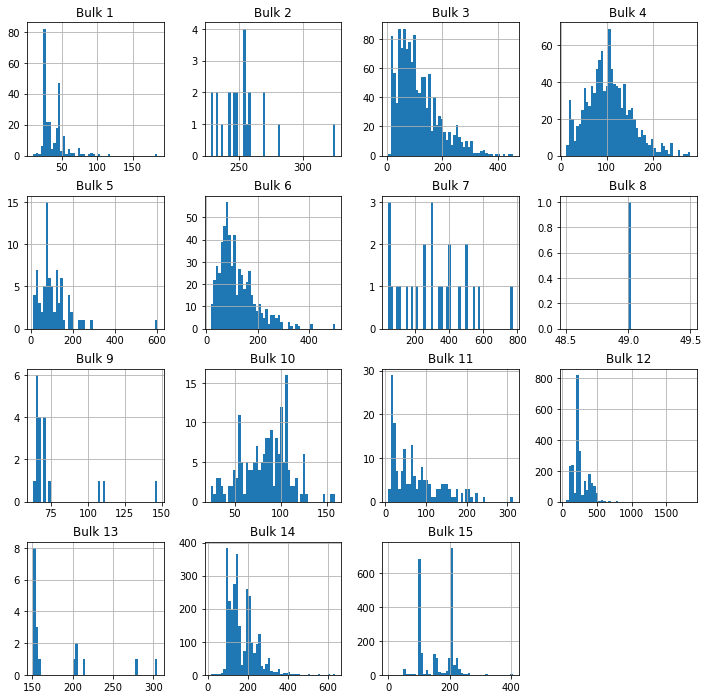

In [20]:
df_bulk.drop('key', axis=1).hist(figsize=(12, 12), bins=50);

**Вывод**

Предварительный обзор данных о подаче сыпучих материалов (объём) показал, что:
- несоответствие наименования колонок (единый стиль);
- обнаружено значительное количество пропусков (71.5%);
- явных дубликатов не обнаружено;
- выявлено несоответствие наименования столбцов.


#### Предобработка данных

**План предобработки:**
- приведение наименований столбцов к единому стилю;
- обработка пропусков;
- обрбаотка выбросов;
- установка ключа в роле индекса.

Приведем наименование колонок к единому стилю

In [21]:
df_bulk.columns = ['key'] + ['bulk_'+ str(i) for i in  range(1,16)]
df_bulk.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

Заполним пропуски значением 0 по условию заказчика

In [22]:
df_bulk = df_bulk.fillna(0)
print('Кол-во пропусков: \n',df_bulk.isna().sum())

Кол-во пропусков: 
 key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64


Проверим уникальность ключей

In [23]:
if df_bulk['key'].nunique() == len(df_bulk):
    print('Ключи уникальны')
else:
    print('Ключи не уникальны!')

Ключи уникальны


Т.к. все ключи уникальны, следовательно агрегировать данные не требуется. Установим ключи в качестве индекса.

In [24]:
df_bulk = df_bulk.set_index('key')
df_bulk.head()  

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


Проверим данные послеобработки

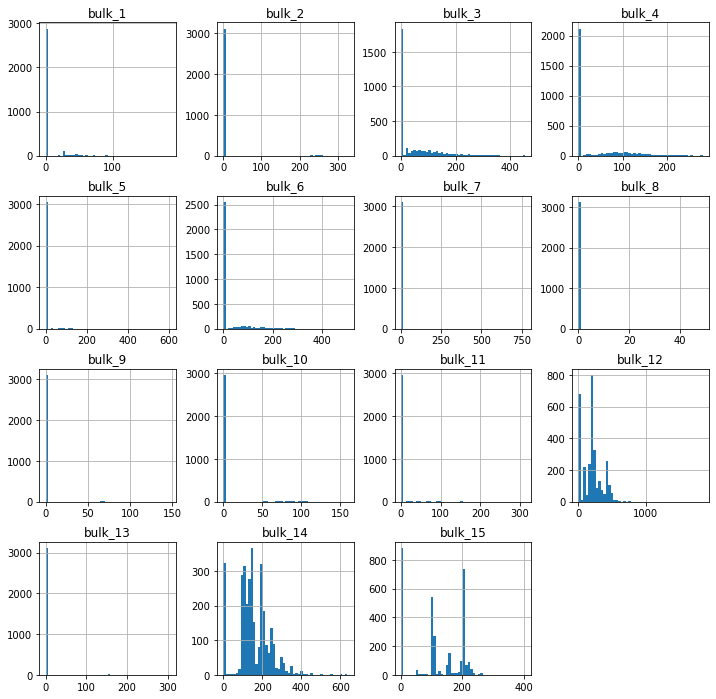

In [25]:
df_bulk.hist(figsize=(12, 12), bins=50);

После заполнения пропусков 0 графики стали не информативны

**Вывод** 

**В результате предобработки данных о подаче сыпучих материалов:**
- наименования колнок приведены к единому стилю;
- обработаны пропуски;
- установлены ключи в роле индекса.

### Данные о подаче сыпучих материалов (время) (data_bulk_time_new)

#### Анализ данных

In [26]:
get_df_info(df_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key
count,3129.0
mean,1624.0
std,933.0
min,1.0
25%,816.0
50%,1622.0
75%,2431.0
max,3241.0


'Кол-во пропусков:'

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

'Доля пропусков:'

0.7146053052093321

Кол-во явных дубликатов: 0


**Вывод**

Предварительный обзор данных о подаче сыпучих материалов (время) показал, что:

- обнаружено значительное количество пропусков во всех колонках, что составило 71.5% от всего датасета;
- явных дубликатов не обнаружено.

**План предобработки:**
Предобработка данных не потребуется, т.к. для обучения данный датасет использоваться не будет.

### Данные о продувке сплава газом (data_gas_new)

#### Анализ данных

In [27]:
get_df_info(df_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.0,3239.0
mean,1622.0,11.0
std,935.0,6.0
min,1.0,0.0
25%,812.0,7.0
50%,1622.0,10.0
75%,2432.0,14.0
max,3241.0,78.0


'Кол-во пропусков:'

key      0
Газ 1    0
dtype: int64

'Доля пропусков:'

0.0

Кол-во явных дубликатов: 0


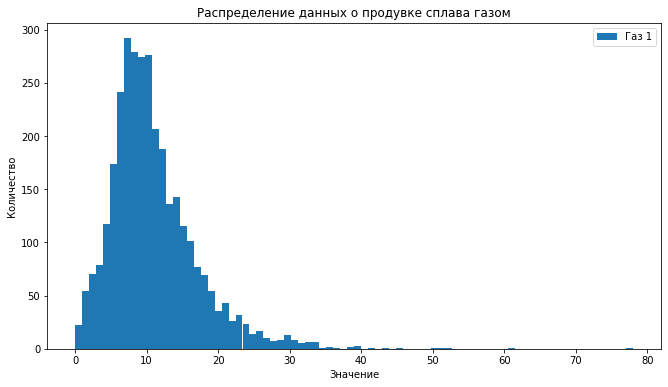

In [28]:
plt.figure(figsize=(11,6))
df_gas['Газ 1'].plot(kind='hist', bins=80, legend=True)
plt.title('Распределение данных о продувке сплава газом')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.show()

**Вывод**

Предварительный обзор данных о продувке сплава газом показал, что:
- несоответствие наименования колонок (единый стиль);
- явных дубликатов не обнаружено
- пропусков не обнаружено;
- распределение близко к нормальному;
- обнаружены выбросы в правой части распределения.

#### Предобработка данных

**План предобработки:**

- приведение наименования столбцов к единому стилю;
- проверка уникальности ключей.

Приведем наименование колонок к единому стилю

In [29]:
df_gas.rename(columns={'Газ 1': 'gas'}, inplace=True)
df_gas.columns

Index(['key', 'gas'], dtype='object')

Проверим уникальность ключей

In [30]:
if df_gas['key'].nunique() == len(df_gas):
    print('Ключи уникальны')
else:
    print('Ключи не уникальны!')

Ключи уникальны


Т.к. все ключи уникальны, следовательно агрегировать данные не требуется. Установим ключи в качестве индекса.

In [31]:
df_gas = df_gas.set_index('key')
df_gas.head()  

,gas
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


**Вывод** 

**В результате предобработки данных о продувке газом:**
- наименования колнок приведены к единому стилю;
- установлены ключи в роле индекса.

### Данные о результатах измерения температуры (data_temp_new)

#### Анализ данных

In [32]:
get_df_info(df_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

,key,Температура
count,18092.0,14665.0
mean,1616.0,1591.0
std,935.0,20.0
min,1.0,1191.0
25%,808.0,1580.0
50%,1618.0,1590.0
75%,2429.0,1599.0
max,3241.0,1705.0


'Кол-во пропусков:'

key                0
Время замера       0
Температура     3427
dtype: int64

'Доля пропусков:'

0.06314024614931092

Кол-во явных дубликатов: 0


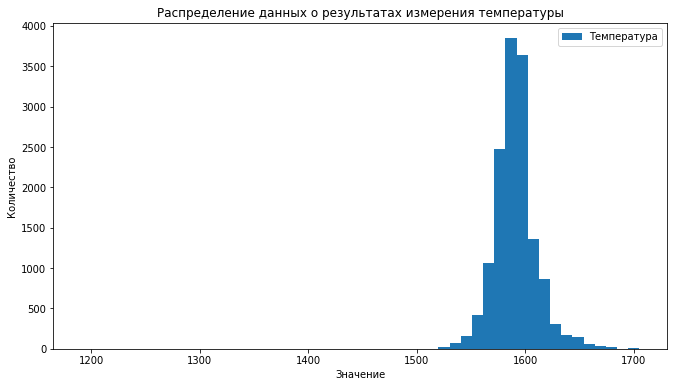

In [33]:
plt.figure(figsize=(11,6))
df_temp['Температура'].plot(kind='hist', bins=50, legend=True)
plt.title('Распределение данных о результатах измерения температуры')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.show()

**Вывод**

Предварительный обзор данных  об измерении температуры показал, что:

- несоответствие наименования колонок (единый стиль);
- выявлен 6,31% пропусков от датасета;
- явных дубликатов нет;
- выявлены значения температуры ниже 1500.

#### Предобработка данных

**План предобработки:**

- приведение наименования столбцов к единому стилю;
- обработка пропусков;
- обрбаотка аномалий;
- агрегировать данные.

Переименуем наименование колонок

In [34]:
df_temp.rename(columns={'Время замера': 'time',
                       'Температура': 'temperature'},
              inplace=True)
df_temp.columns

Index(['key', 'time', 'temperature'], dtype='object')

Изменим тип данных колонки времени замера

In [35]:
df_temp['time'] = pd.to_datetime(df_temp['time'], format='%Y-%m-%dT%H:%M:%S')
df_temp.dtypes

key                     int64
time           datetime64[ns]
temperature           float64
dtype: object

Удалим пропуски

In [36]:
# создадим список с ключами, в которых обнаружены пропуски
value = list(df_temp[df_temp['temperature'].isnull() == True]['key'].unique())
# удалим строки с пропусками по ключу
df_temp = df_temp.loc[df_temp['key'].isin(value) == False]

Удалим ключи со значением температуры ниже 1500

In [37]:
key_temperature = df_temp.loc[df_temp['temperature'] < 1500]['key'].unique()
df_temp = df_temp.query('key not in @key_temperature')

In [38]:
if len(df_temp.loc[df_temp['temperature'] < 1500]) == 0:
    print('Удаление проведено корректно')
else:
    print('Хьюстон, у нас проблемы!')

Удаление проведено корректно


Удалим ключи с одной записью

In [39]:
df_temp_1 = len(df_temp)
X = df_temp['key'].value_counts()
df_temp_del = df_temp[df_temp.key.isin(X[X.values > 1].index)]

# Проверка удаления
print('Кол-во удаленных ключей:', df_temp_1 - len(df_temp_del))
print('Кол-во уникальных значений ключей в порядке возростания: \n', df_temp_del['key'].
      value_counts().
      sort_values().
      head(10))

Кол-во удаленных ключей: 2
Кол-во уникальных значений ключей в порядке возростания: 
 1268    2
248     2
1281    2
943     2
1988    2
2194    2
1911    2
1169    2
556     2
977     2
Name: key, dtype: int64


Создадим датасет с одной записью для каждого ключа, добавив значения первого и последнего замеров

In [40]:
columns=['temperature_start', 'temperature_end']
df_temp_full = pd.DataFrame(data=None, index=None, columns=columns)

for key in df_temp['key'].unique():
    tmp = df_temp[df_temp['key'] == key].reset_index(drop=True)
    time_min = tmp['time'].min()
    time_max = tmp['time'].max()
    
    df_temp_full = pd.concat([df_temp_full, 
                                pd.DataFrame([[tmp[tmp['time'] == time_min]['temperature'].iloc[0],
                                               tmp[tmp['time'] == time_max]['temperature'].iloc[0],
                                              ]], index=[key], columns=columns)
                               ])

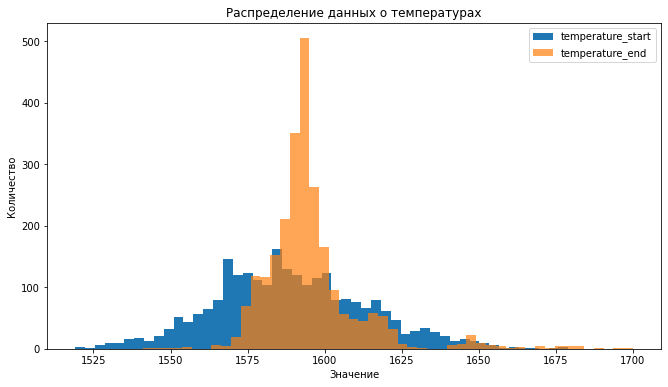

In [41]:
plt.figure(figsize=(11,6))
df_temp_full['temperature_start'].plot(kind='hist', bins=50, legend=True)
df_temp_full['temperature_end'].plot(kind='hist', bins=50, legend=True, alpha=0.7)
plt.title('Распределение данных о температурах')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.show()

In [42]:
df_temp_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2473 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temperature_start  2473 non-null   float64
 1   temperature_end    2473 non-null   float64
dtypes: float64(2)
memory usage: 58.0 KB


In [43]:
df_temp_full.head()

,temperature_start,temperature_end
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


In [44]:
df_temp_full.isna().sum()

temperature_start    0
temperature_end      0
dtype: int64

**Вывод**

**В результате предобработки данных  об измерении температуры:**

- приведены наименования колонок к единому стилю;
- удалены пропуски;
- удалены значения температуры ниже 1500;
- удалены ключи с единичным замером;
- ключ установлен в качестве индекса.

###  Данные о проволочных материалах (объём) (data_wire_new)

#### Анализ данных

In [45]:
get_df_info(df_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.0,3055.0,1079.0,63.0,14.0,1.0,73.0,11.0,19.0,29.0
mean,1623.0,101.0,51.0,189.0,57.0,15.0,48.0,10.0,54.0,34.0
std,933.0,42.0,39.0,100.0,29.0,NaN,34.0,9.0,17.0,20.0
min,1.0,2.0,0.0,0.0,24.0,15.0,0.0,0.0,45.0,5.0
25%,823.0,72.0,20.0,95.0,41.0,15.0,25.0,7.0,46.0,22.0
50%,1619.0,100.0,40.0,235.0,45.0,15.0,42.0,9.0,46.0,30.0
75%,2434.0,126.0,70.0,276.0,76.0,15.0,64.0,12.0,48.0,44.0
max,3241.0,330.0,283.0,385.0,113.0,15.0,180.0,33.0,103.0,90.0


'Кол-во пропусков:'

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

'Доля пропусков:'

0.7590068159688413

Кол-во явных дубликатов: 0


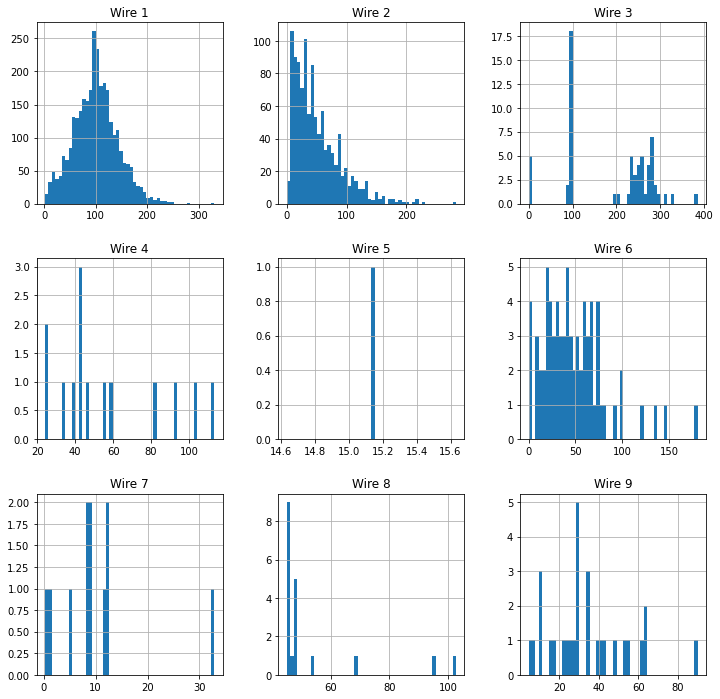

In [46]:
df_wire.drop('key', axis=1).hist(figsize=(12, 12), bins=50);

**Вывод**

Предварительный обзор данных о  о проволочных материалах (объём) показал, что:
- несоответствие наименования колонок (единый стиль);
- обнаружено значительное количество пропусков (75.9%);
- явных дубликатов не обнаружено
- выявлено несоответствие наименования столбцов.


#### Предобработка данных

**План предобработки:**
- приведение наименований колонок к единому стилю;
- обработка пропусков;
- обрбаотка выбросов;
- установка ключа в роле индекса.

Приведем наименование колонок к единому стилю

In [47]:
df_wire.columns = ['key'] + ['wire_'+ str(i) for i in  range(1,10)]
df_wire.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

Заполним пропуски значением 0 по условию заказчика

In [48]:
df_wire = df_wire.fillna(0)
print('Кол-во пропусков: \n',df_wire.isna().sum())

Кол-во пропусков: 
 key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_5    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64


Проверим уникальность ключей

In [49]:
if df_wire['key'].nunique() == len(df_wire):
    print('Ключи уникальны')
else:
    print('Ключи не уникальны!')

Ключи уникальны


Т.к. все ключи уникальны, следовательно агрегировать данные не требуется. Установим ключи в качестве индекса.

In [50]:
df_wire = df_wire.set_index('key')
df_wire.head()  

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


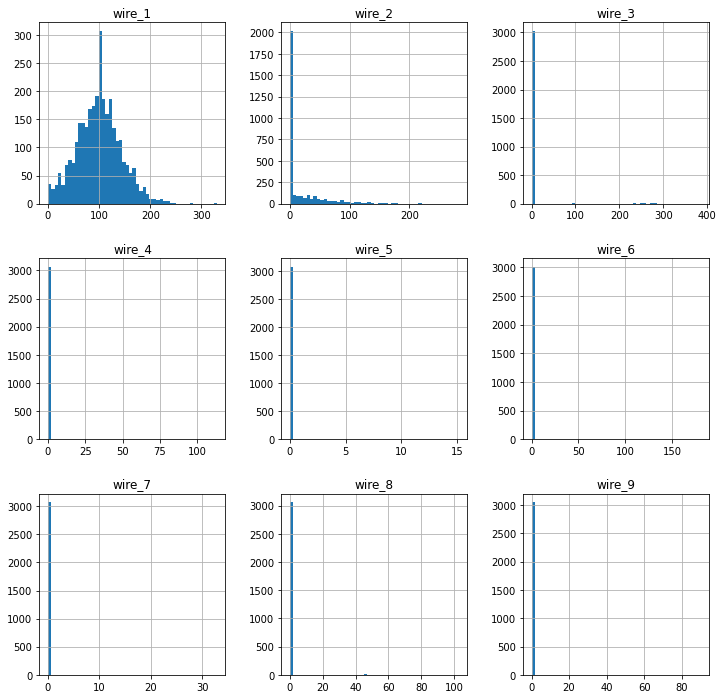

In [51]:
df_wire.hist(figsize=(12, 12), bins=50);

**Вывод** 

**В результате предобработки данных о проволчных материалах:**
- наименования колнок приведены к единому стилю;
- обработаны пропуски;
- установлены ключи в роле индекса.

###  Данные о проволочных материалах (время) (data_wire_time_new)

#### Анализ данных

In [52]:
get_df_info(df_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.0
mean,1623.0
std,933.0
min,1.0
25%,823.0
50%,1619.0
75%,2434.0
max,3241.0


'Кол-во пропусков:'

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

'Доля пропусков:'

0.7590068159688413

Кол-во явных дубликатов: 0


**Вывод**

Предварительный обзор данных о подачепроволочных материалах (время) показал, что:

- обнаружено значительное количество пропусков во всех колонках, что составило 75.9% от всего датасета;
- явных дубликатов не обнаружено.

**План предобработки:**
Предобработка данных не потребуется, т.к. для обучения данный датасет использоваться не будет.

# **План выполнения проекта:**

1) Выполнить локаоьные планы по предобработке данных всех датасетов.

2) Выполнить объединение датасетов в один для разделения на выборки.

3) Выполнить предобработку данных объединенного датасета.

4) Разделить датасет на выборки в отношении 75% к 25%.

5) Обучить не менее 2 моделей машинного обучения с подбором гиперпараметров.

6) Проверить лучшую модель на тестовой выборке и сравнить ее с константной моделью, также рассчитать метрику R2 и интерпретировать ее.

7) Составить вывод.

Дополнительных вопросов нет.

## Объединение датасетов

При объединении данных по ключу используем только INNER (т.е. беремтолько те партии, которые представлены во всех таблицах). По условию заказчика в объединенную таблицу не включаем данные из df_bulk_time и df_wire_time.

In [53]:
df_total = pd.concat(
    [df_arc_del,
     df_bulk,
     df_gas,
     df_wire,
     df_temp_full]
    ,join='inner',axis=1
)

In [54]:
get_df_info(df_total)
print(df_total.tail())

,full_power,time_heat,energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,temperature_start,temperature_end
1,3.718736,1098.0,770.282114,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1571.0,1613.0
2,2.588349,811.0,481.760005,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1581.0,1602.0
3,5.019223,655.0,722.837668,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1596.0,1599.0
4,3.400038,741.0,683.455597,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1601.0,1625.0
5,2.816980,869.0,512.169934,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1576.0,1602.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2300 entries, 1 to 2499
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   full_power         2300 non-null   float64
 1   time_heat          2300 non-null   float64
 2   energy             2300 non-null   float64
 3   bulk_1             2300 non-null   float64
 4   bulk_2             2300 non-null   float64
 5   bulk_3             2300 non-null   float64
 6   bulk_4             2300 non-null   float64
 7   bulk_5             2300 non-null   float64
 8   bulk_6             2300 non-null   float64
 9   bulk_7             2300 non-null   float64
 10  bulk_8             2300 non-null   float64
 11  bulk_9             2300 non-null   float64
 12  bulk_10            2300 non-null   float64
 13  bulk_11            2300 non-null   float64
 14  bulk_12            2300 non-null   float64
 15  bulk_13            2300 non-null   float64
 16  bulk_14            2300 

None

,full_power,time_heat,energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,temperature_start,temperature_end
count,2300.0,2300.0,2300.0,2300.0,2300.0,2300.0,2300.0,2300.0,2300.0,2300.0,...,2300.0,2300.0,2300.0,2300.0,2300.0,2300.0,2300.0,2300.0,2300.0,2300.0
mean,4.0,815.0,676.0,3.0,1.0,48.0,37.0,3.0,22.0,2.0,...,18.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1587.0,1593.0
std,1.0,335.0,316.0,12.0,19.0,76.0,59.0,23.0,56.0,31.0,...,34.0,28.0,5.0,0.0,9.0,0.0,4.0,3.0,23.0,11.0
min,1.0,119.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1519.0,1541.0
25%,3.0,588.0,465.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1571.0,1587.0
50%,4.0,782.0,635.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1586.0,1593.0
75%,5.0,996.0,845.0,0.0,0.0,80.0,78.0,0.0,0.0,0.0,...,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1603.0,1598.0
max,15.0,4189.0,4546.0,185.0,325.0,454.0,281.0,603.0,503.0,772.0,...,283.0,385.0,113.0,0.0,180.0,8.0,103.0,62.0,1660.0,1653.0


'Кол-во пропусков:'

full_power           0
time_heat            0
energy               0
bulk_1               0
bulk_2               0
bulk_3               0
bulk_4               0
bulk_5               0
bulk_6               0
bulk_7               0
bulk_8               0
bulk_9               0
bulk_10              0
bulk_11              0
bulk_12              0
bulk_13              0
bulk_14              0
bulk_15              0
gas                  0
wire_1               0
wire_2               0
wire_3               0
wire_4               0
wire_5               0
wire_6               0
wire_7               0
wire_8               0
wire_9               0
temperature_start    0
temperature_end      0
dtype: int64

'Доля пропусков:'

0.0

Кол-во явных дубликатов: 0
      full_power  time_heat      energy  bulk_1  bulk_2  bulk_3  bulk_4  \
2495    3.868721      723.0  694.177326     0.0     0.0    21.0     0.0   
2496    5.070316      940.0  815.818538     0.0     0.0     0.0    63.0   
2497    4.360918      569.0  823.020520     0.0     0.0     0.0    85.0   
2498    3.909917      750.0  581.810739     0.0     0.0    90.0     0.0   
2499    2.169252      883.0  532.386183     0.0     0.0    47.0     0.0   

      bulk_5  bulk_6  bulk_7  ...    wire_2  wire_3  wire_4  wire_5  wire_6  \
2495     0.0     0.0     0.0  ...   0.00000     0.0     0.0     0.0     0.0   
2496     0.0     0.0     0.0  ...   0.00000     0.0     0.0     0.0     0.0   
2497     0.0     0.0     0.0  ...   9.04800     0.0     0.0     0.0     0.0   
2498     0.0     0.0     0.0  ...   0.00000     0.0     0.0     0.0     0.0   
2499     0.0     0.0     0.0  ...  50.00528     0.0     0.0     0.0     0.0   

      wire_7  wire_8  wire_9  temperature_start

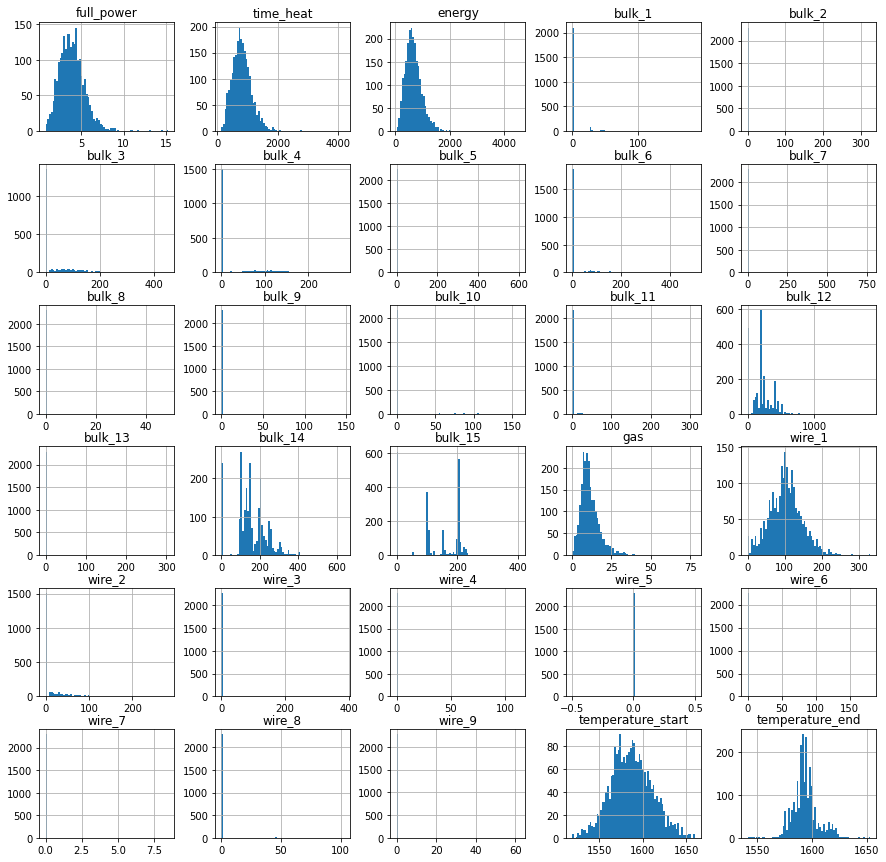

In [55]:
df_total.hist(figsize=(15, 15), bins=70);

Построим матрицу корреляции признаков. 

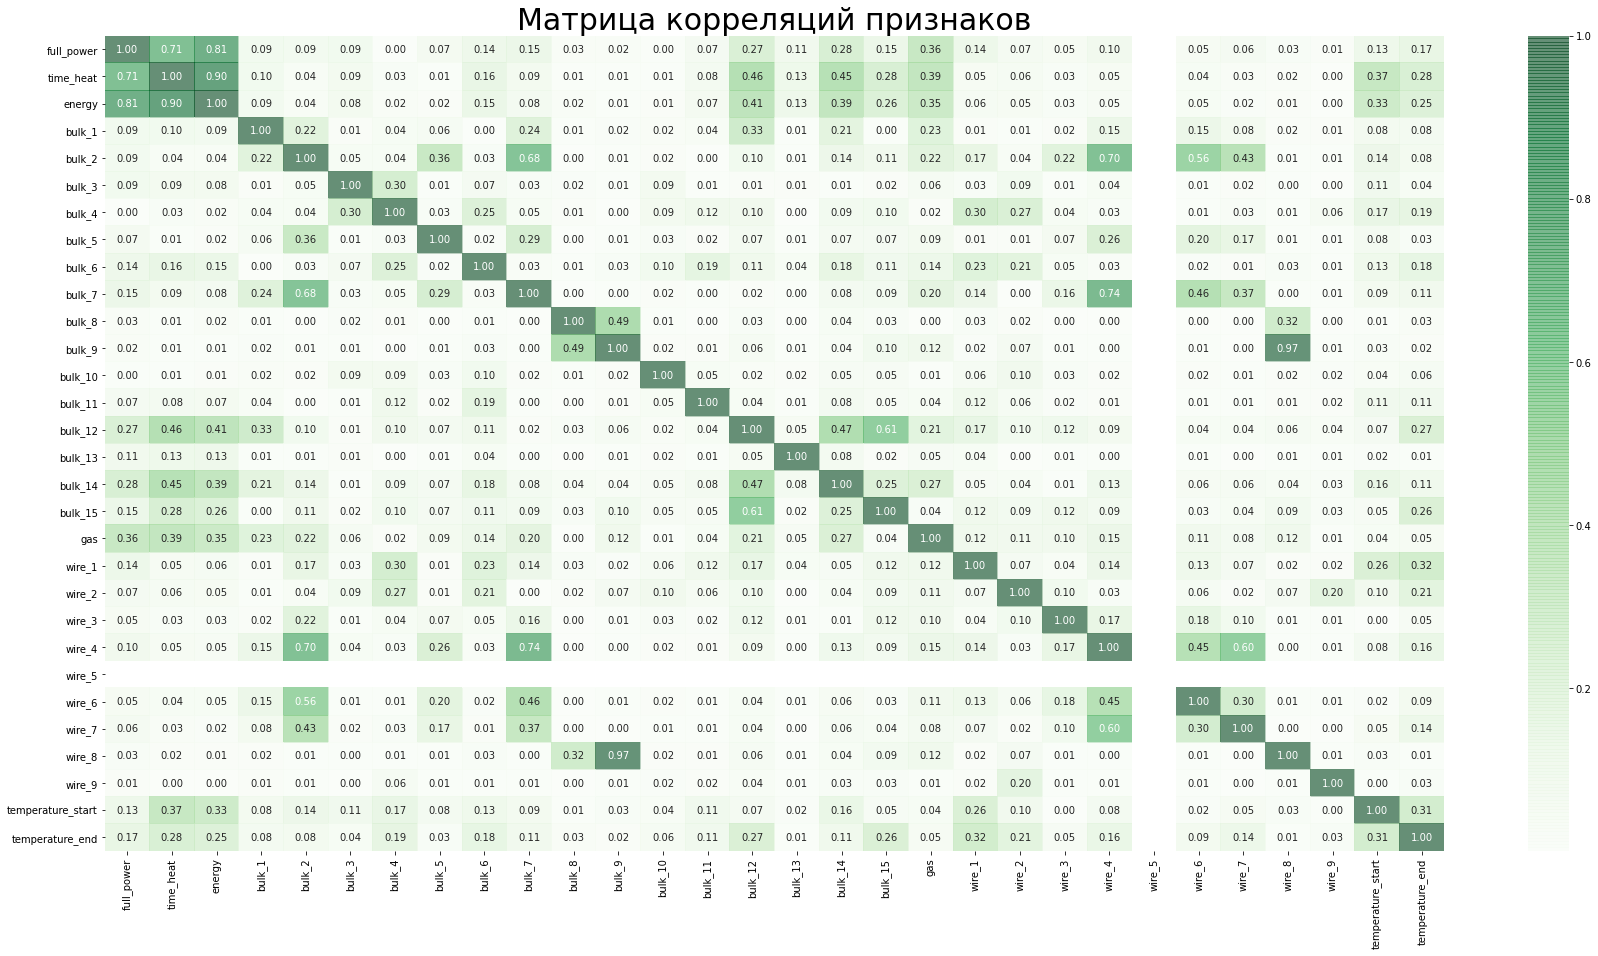

In [56]:
plt.figure(figsize=(30, 15))
sns.heatmap(df_total.corr().abs(), cmap='Greens', alpha=0.6,
           annot=True, fmt='.2f'
           );
plt.title('Матрица корреляций признаков', fontsize=30)
plt.show()

Исключаям bulk_9 и wire_8 из признаков из-за высокой корреляции

In [57]:
df_total= df_total.drop('wire_8', axis=1)
df_total= df_total.drop('energy', axis=1)

## Разделение на выборки

In [58]:
RANDOM_STATE = 280823

In [59]:
features = df_total.drop(['temperature_end'], axis=1)
target = df_total['temperature_end']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)

In [60]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1725, 27)
(575, 27)
(1725,)
(575,)


### Масштабирование выборок для линейных моделей  

In [61]:
pd.options.mode.chained_assignment = None     

scaler = StandardScaler()
scaler.fit(X_train)

X_train_sc = X_train.copy()
X_test_sc = X_test.copy()

X_train_sc[X_train.columns] = scaler.transform(X_train[X_train.columns])
X_test_sc[X_train.columns] = scaler.transform(X_test[X_train.columns])

display(X_train_sc.sample(4), X_test_sc.sample(4))

,full_power,time_heat,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,...,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_9,temperature_start
364,-0.718610,-0.554616,3.408881,-0.063689,-0.627226,2.028705,-0.093034,-0.414426,-0.054217,-0.024084,...,1.242393,0.443535,-0.527940,-0.1116,-0.059016,0.0,-0.111852,-0.033009,-0.09718,1.355368
39,-0.623372,-0.304834,-0.278808,-0.063689,-0.627226,1.324397,-0.093034,-0.414426,-0.054217,-0.024084,...,-0.183607,0.737934,-0.527940,-0.1116,-0.059016,0.0,-0.111852,-0.033009,-0.09718,-0.054539
2126,-1.850030,-1.503197,-0.278808,-0.063689,0.141846,-0.633922,-0.093034,-0.414426,-0.054217,-0.024084,...,-0.255820,-0.084396,-0.527940,-0.1116,-0.059016,0.0,-0.111852,-0.033009,-0.09718,1.355368
2429,-0.499140,-0.069919,-0.278808,-0.063689,-0.322249,-0.633922,-0.093034,0.584930,-0.054217,-0.024084,...,-0.490569,-0.403197,0.378601,-0.1116,-0.059016,0.0,-0.111852,-0.033009,-0.09718,-1.037201


,full_power,time_heat,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,...,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_9,temperature_start
2227,-0.851604,-1.030394,-0.278808,-0.063689,-0.627226,0.826228,-0.093034,-0.414426,-0.054217,-0.024084,...,0.118008,-0.470732,-0.527940,-0.111600,-0.059016,0.0,-0.111852,-0.033009,-0.09718,0.201808
1636,-0.633764,-0.173995,-0.278808,-0.063689,0.009247,-0.633922,-0.093034,-0.414426,-0.054217,-0.024084,...,-0.848973,-0.968513,1.504525,-0.111600,-0.059016,0.0,-0.111852,-0.033009,-0.09718,-0.909028
407,-0.411588,0.453436,-0.278808,-0.063689,-0.627226,-0.633922,-0.093034,-0.414426,-0.054217,-0.024084,...,0.741375,0.603149,2.733795,10.017125,-0.059016,0.0,-0.111852,-0.033009,-0.09718,-1.421721
1709,-1.450866,-1.446699,-0.278808,-0.063689,-0.627226,-0.273179,-0.093034,-0.414426,-0.054217,-0.024084,...,-1.043512,0.165808,-0.100959,-0.111600,-0.059016,0.0,-0.111852,-0.033009,-0.09718,0.629053


## Обучение моделей

### Модель Ridge

In [62]:
%%time
model_ridge = Ridge(random_state=RANDOM_STATE)


param_grid_ridge = {
    'alpha': np.arange(0, 0.21, 0.01),
    'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

gs_ridge = GridSearchCV(
    model_ridge,
    param_grid=param_grid_ridge,
    scoring='neg_mean_absolute_error',
    verbose=3
)


model_ridge = gs_ridge.fit(X_train_sc, y_train)

MAE_ridge = model_ridge.best_score_ * -1


print('Лучшие гиперпараметры ridge: '+str(model_ridge.best_params_))

print('MAE_ridge:', MAE_ridge)

Fitting 5 folds for each of 126 candidates, totalling 630 fits
[CV 1/5] END ............alpha=0.0, solver=svd;, score=-6.182 total time=   0.3s
[CV 2/5] END ............alpha=0.0, solver=svd;, score=-6.615 total time=   0.4s
[CV 3/5] END alpha=0.0, solver=svd;, score=-1569559313113.339 total time=   0.0s
[CV 4/5] END ............alpha=0.0, solver=svd;, score=-6.241 total time=   0.3s
[CV 5/5] END ............alpha=0.0, solver=svd;, score=-7.032 total time=   0.3s
[CV 1/5] END .......alpha=0.0, solver=cholesky;, score=-6.182 total time=   0.0s
[CV 2/5] END .......alpha=0.0, solver=cholesky;, score=-6.615 total time=   0.1s
[CV 3/5] END alpha=0.0, solver=cholesky;, score=-1569559313113.339 total time=   0.2s
[CV 4/5] END .......alpha=0.0, solver=cholesky;, score=-6.241 total time=   0.3s
[CV 5/5] END .......alpha=0.0, solver=cholesky;, score=-7.032 total time=   0.4s
[CV 1/5] END ...........alpha=0.0, solver=lsqr;, score=-6.182 total time=   0.2s
[CV 2/5] END ...........alpha=0.0, solver

### Модель LGBMRegressor

In [63]:
%%time
lgbmr_space={'num_leaves':[25, 50, 100, 200],
             'learning_rate':[.1, .3, .5]
          }

lgbmr = LGBMRegressor(random_state=RANDOM_STATE)

lgbmr_random = GridSearchCV(lgbmr,
                                lgbmr_space,
                                scoring='neg_mean_absolute_error',
                                cv=3,
                                error_score='raise',
                                verbose=3
                                 )


model_lgbmr = lgbmr_random.fit(X_train, y_train)

MAE_lgbmr = model_lgbmr.best_score_ * -1


print('Лучшие гиперпараметры lgbmr: '+str(model_lgbmr.best_params_))

print('MAE_lgbmr:', MAE_lgbmr)



Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END .learning_rate=0.1, num_leaves=25;, score=-6.669 total time= 5.0min
[CV 2/3] END .learning_rate=0.1, num_leaves=25;, score=-6.827 total time= 5.4min
[CV 3/3] END .learning_rate=0.1, num_leaves=25;, score=-6.279 total time= 5.1min
[CV 1/3] END .learning_rate=0.1, num_leaves=50;, score=-6.625 total time= 7.6min
[CV 2/3] END .learning_rate=0.1, num_leaves=50;, score=-6.913 total time= 7.8min
[CV 3/3] END .learning_rate=0.1, num_leaves=50;, score=-6.434 total time= 8.1min
[CV 1/3] END learning_rate=0.1, num_leaves=100;, score=-6.625 total time= 7.6min
[CV 2/3] END learning_rate=0.1, num_leaves=100;, score=-6.913 total time= 1.4min
[CV 3/3] END learning_rate=0.1, num_leaves=100;, score=-6.434 total time= 7.7min
[CV 1/3] END learning_rate=0.1, num_leaves=200;, score=-6.625 total time=  35.8s
[CV 2/3] END learning_rate=0.1, num_leaves=200;, score=-6.913 total time=   1.8s
[CV 3/3] END learning_rate=0.1, num_leaves=200;,

### Модель RandomForestRegressor

In [64]:
%%time

rfr_space={'max_depth': range(4, 40, 2),
          'n_estimators':range(10, 100, 20),
          'min_samples_leaf':range(1,5),
          'min_samples_split':range(2, 10, 2)
          }

rfr = RandomForestRegressor(random_state=RANDOM_STATE)
rfr_random = RandomizedSearchCV(rfr,
                                rfr_space,
                                n_iter=5,
                                scoring='neg_mean_absolute_error',
                                cv=5,
                                error_score='raise',
                                verbose=3)

model_rfr = rfr_random.fit(X_train, y_train)

MAE_rfr = model_rfr.best_score_ * -1


print('Лучшие гиперпараметры rfr: '+str(model_rfr.best_params_))

print('Best MAE_rfr:', MAE_rfr)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=30;, score=-6.425 total time=   0.3s
[CV 2/5] END max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=30;, score=-6.758 total time=   0.3s
[CV 3/5] END max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=30;, score=-6.264 total time=   0.3s
[CV 4/5] END max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=30;, score=-6.065 total time=   0.3s
[CV 5/5] END max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=30;, score=-6.629 total time=   0.3s
[CV 1/5] END max_depth=38, min_samples_leaf=3, min_samples_split=8, n_estimators=10;, score=-6.614 total time=   0.1s
[CV 2/5] END max_depth=38, min_samples_leaf=3, min_samples_split=8, n_estimators=10;, score=-6.911 total time=   0.1s
[CV 3/5] END max_depth=38, min_samples_leaf=3, min_samples_split=8, n_estimators=10;, score=-6.588 total time=   0

### Визуализация важности признаков

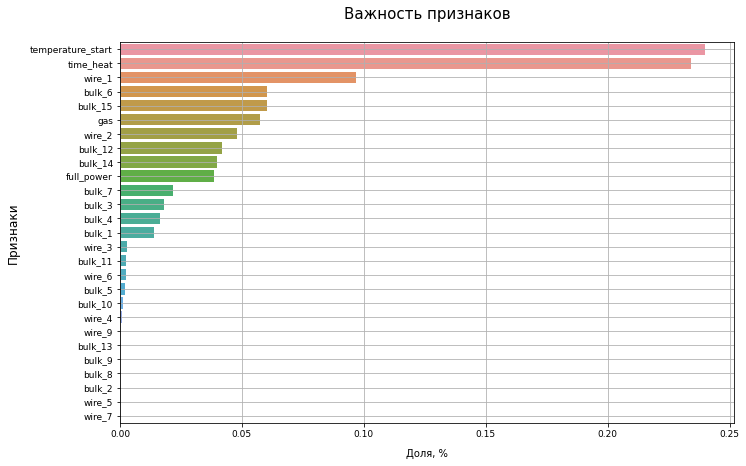

In [65]:

feature_importances = pd.Series(model_rfr.best_estimator_.feature_importances_, X_train.columns)
feature_importances.sort_values(inplace=True, ascending=False)

plt.figure(figsize=(11, 7))
sns.barplot(x=feature_importances.values,
            y=feature_importances.index,            
            orient='h');
plt.title('Важность признаков\n', fontsize=15)
plt.xlabel('Доля, %', fontsize=10, labelpad=10)
plt.ylabel('Признаки', fontsize=12, labelpad=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid('on')
plt.show()

**Вывод:**

Наиболее важные данные на которых строилось предсказание лучшей моделей, ТОП-3 из которых  "temperature_start, time_heat, wire_1", то есть температура в начале замера, время нагрева в секундах и первый проволочный материал для выполнения технологических операций. Следовательно, заказчику необходимо обратить внимание на эти данные для достижения целей по оптимизации производственных расходов на энергоресурсы.

Выбор лучшей модели

In [66]:
index = ['Ridge','LGBMRegressor','RandomForestRegressor']
data = {'Best MAE train':[MAE_ridge,
                          MAE_lgbmr,
                          MAE_rfr],
        'Best_params ':[model_ridge.best_params_,
                        model_lgbmr.best_params_,
                        model_rfr.best_params_]
       }

scores_df = pd.DataFrame(data=data, index=index)
scores_df

,Best MAE train,Best_params
Ridge,6.508942,"{'alpha': 0.2, 'solver': 'saga'}"
LGBMRegressor,6.591713,"{'learning_rate': 0.1, 'num_leaves': 25}"
RandomForestRegressor,6.388673,"{'n_estimators': 70, 'min_samples_split': 2, '..."


**Вывод:** Лучшая модель по метрикам RandomForestRegressor.

## Тестирование моделей

### Тестирование лучшей модели

In [67]:
%%time
rfr_prediction = rfr_random.predict(X_test)
mae_test_rfr = mean_absolute_error(y_test, rfr_prediction)
R2_test_rfr = r2_score(y_test, rfr_prediction)
print('Значение MAE на тестовой выборке:',mae_test_rfr)
print('Значение R2 на тестовой выборке:',R2_test_rfr)

Значение MAE на тестовой выборке: 6.004405247286704
Значение R2 на тестовой выборке: 0.40162866837615185
CPU times: user 14.2 ms, sys: 0 ns, total: 14.2 ms
Wall time: 13.3 ms


### Сравнение с константной моделью

In [68]:
dummy = DummyRegressor(strategy='median').fit(X_train, y_train)
dummy_predict = dummy.predict(X_test)
dummy_score = mean_absolute_error(y_test.values, dummy_predict).round(3)

print('Значение MAE dummy-модели по медиане на тестовой выборке =', dummy_score) 

Значение MAE dummy-модели по медиане на тестовой выборке = 7.6


**Вывод:** 
Метрика лучшей модели лучше, чем у константной. Модель адекватна.

**Итоговый вывод:**
Разработана модель машинного обучения на базе RandomForestRegressor, прогнозирующая температуру стали. Заказчиком проекта является Металлургический комбинат ООО «Так закаляем сталь». Разработанная модель машинного обучения, предскажет температуру стали для оптимизации производственных расходов (потребление электроэнергии) на этапе обработки стали.
Метрика MAE модели на тестовой выборке = 6.004405247286704. Модель проверена на адекватность, произведено сравнение метрик с константной моделью DummyRegressor.

## Итоговый вывод

**Выполнение плана**
Запланированные мероприятия выполнены в полном объеме.

**Описание сложностей проекта**

В ходе выполнения проекта встретились сложнасти с пониманием технологического процесса по изготовлению стали. 
В ходе встречи с представителем заказчика (тим-лидом) был детально проработанн технолгический процесс с детальным обзором технологических операций. Данных сведений было достаточно для понимания. 

**Описание шагов решения:**

**В ходе проведения исследовательского анализа и предобработки данных выполнены следующие шаги:**

- произведена загрузка данных;
- разработана ф-ия по проведению исследоваельского  анализа данных;
- проведен анализ данных, выявлены аномалии (выбросы) и составлены по каждому датасету планы проведения предобработки;
- выполнены все пункты планов по предобработке, среди которых можно выделить:
	- обработка аномалий и пропусков;
	- разработка новых признаков;
	- агрегирование данных по ключ;
	- выбор ключей в роле индекса.

**Подготовка данных к обучению:**

- провдено объединение всех датасетов за исключением df_bulk_time и df_wire_time;
- проведен анализ и предобработка объединенных данных;
- все признаки проверены на мультиколлениарность, среди высокококоррелирующих признаков удалены wire_8 и energy;
- все данные разделены на обучающуую и тестовую выборки в отношении 75/25(%);
- проведно масштабирование признаков с использованием StandardScaler для обучения линейных моделей;
- итоговоый перечень используемых для обучения признаков:  'full_power', 'heating_time', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'gas', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_9', 'temperature_start', 'temperature_end'.


**Обучение моделей:**

1) Для обучения были выбраны модели машинного обучения:
- Ridge;
- LGBMRegressor;
- RandomForestRegressor.

2) Подбор гиперпараметров осуществлялся при помощи RandomizedSearchCV и GridSearchCV.

3) Лучшее значение оцениваемой мерики показала модель RandomForestRegressor (MAE = 6.388673, перечень лучших гиперпараметров: 'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 4 и 'max_depth': 18 ) и была выбрана для проведения оценки на тестовом наборе данных.

4) Произведена оценка важности признаков на которых строилось предсказание RandomForestRegressor. Среди наиболее значимых признаков: "temperature_start, time_heat, wire_1", т.е. температура в начале замера, время нагрева в секундах и первый проволочный материал для выполнения технологических операций.  

**Тестирование модели:**

Для проведения тестирования введена дополнительная метрика R2 и провдено сравнение с констатной моделью DummyRegressor.
В результате:
- значение MAE RandomForestRegressor на тестовой выборке: 6.004405247286704;
- значение R2 RandomForestRegressor на тестовой выборке: 0.40162866837615185;
- значение MAE DummyRegressor по медиане на тестовой выборке = 7.6. 

Значение метрики RandomForestRegressor лучше DummyRegressor на 1.6, следовательно можно сделать вывод о том, что модель  можно применять и запускать в промыщленную эксплуатацию.Также, заказчику стоит обратить пристальное внимание на перечень значимых признаков ,чтобы достигнуть цели по оптимизации производственных расходов на энергоресурсы.

*П р и м е ч а н и е: В ходе обучения и тестирования использовано констатное значение RANDOM_STATE = 280823.*
